# Capstone Project

### Business Problem
36,560 people died in motor vehicle crashes in the United States in 2018. Understanding whether someone who has been in a car accident is likely to be gravely injured, may enable our medical and emergency services teams to better prepare when there is an accident. For this project, we have built a number supervised machine learning models to predict the severity of road accidents based on historical car collision data. These models will enable us to predict, based on information from the crash scene, whether the people involved are likely to be severely injured, and thus in need of more immediate and thorough care. Information like this will enable hospitals and emergency officials to better allocate resources when there are car collisions, with the hope that such a move can reduce the chances that people involved in those car collisions will die from their injuries.


### Data
Based on our business problem, we will use the 'Seattle Accident Collisions' dataset, bringing together data from 2004-2015. The data that we will use relates to certain physical characteristics of the accident scene and the environment, factors that could all be discerned by first responders. This includes data on:
1. The type of collison that took place
2. Where the collison took place
3. What the lighting was like around the collison scene
4. What the weather was like at the time of the collison
5. Whether a driver was speeding

Taken together, our models will predict the severity of the road collisions based on those factors. We will also compare a number of predictive models and show which is the best at doing so.

### Data preparation
The data preparation includes all the required activities to construct the final dataset and it includes balancing the labeled data, transformation, filling missing data, and cleaning the dataset.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
df = pd.read_csv('collisions.csv', header=0)

This dataset describes the conditions surrounding car collisions that took place between 2004 and present and is provided by the Seattle Department of Transportation.

We want to focus on a few key variables, including the type of collision, the junction where the collision happened, the weather at the time of the collision, the condition of the roads and also the lighting. Because of this, we can remove columns with daat that we are not interested in.

In [2]:
cols_to_drop = [
    'X','Y','OBJECTID','INCKEY','COLDETKEY','REPORTNO','STATUS','ADDRTYPE','INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC','EXCEPTRSNDESC','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT', 'INJURIES',
    'FATALITIES','INCDATE','SDOT_COLCODE','SDOT_COLDESC','PEDROWNOTGRNT','SDOTCOLNUM','ST_COLCODE','ST_COLDESC','SEGLANEKEY','CROSSWALKKEY', 'HITPARKEDCAR','LOCATION','SEVERITYDESC','SERIOUSINJURIES',
    'INCDTTM','SPEEDING','INATTENTIONIND','UNDERINFL','JUNCTIONTYPE'
]
dataframe = df.drop(cols_to_drop, axis=1)

In [3]:
dataframe.head()

,SEVERITYCODE,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND
0,0,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN
2,1,Left Turn,Overcast,Dry,Daylight
3,1,Parked Car,Clear,Dry,Other
4,1,Rear Ended,Clear,Dry,Daylight


### Feature engineering

We can also move our columns around so that we can have our variable of interest, 'SEVERITYCODE' at the end of the dataset.

In [4]:
dataframe = dataframe[['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEVERITYCODE']]

Now we are going to remove rows where there are missing values. 

In [5]:
dataframe = dataframe.dropna(subset=['COLLISIONTYPE', 'ROADCOND', 'LIGHTCOND', 'WEATHER'])

We can now see that our data is looking a lot cleaner

In [6]:
dataframe.head()

,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SEVERITYCODE
2,Left Turn,Overcast,Dry,Daylight,1
3,Parked Car,Clear,Dry,Other,1
4,Rear Ended,Clear,Dry,Daylight,1
5,Angles,Clear,Dry,Daylight,2
6,Parked Car,Clear,Dry,Dark - Street Lights On,1


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194262 entries, 2 to 221143
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   COLLISIONTYPE  194262 non-null  object
 1   WEATHER        194262 non-null  object
 2   ROADCOND       194262 non-null  object
 3   LIGHTCOND      194262 non-null  object
 4   SEVERITYCODE   194262 non-null  object
dtypes: object(5)
memory usage: 8.9+ MB


We can see from the above that our data is an 'object' type. As it came from a CSV file, we can assume that this means they are all text data and thus categorical variables. Because of this we will need to do some data processing to convert it all to numerical variables, and also balance the categories so that our models are not biased.

First, as we want out models to predict if an accident causes severe injuries, or just mild ones, we can remove rows with a '0' value (unknown) or 1 (property damage).

In [8]:
# Remove categories of no interest
dataframe = dataframe[dataframe.SEVERITYCODE != '1']
dataframe = dataframe[dataframe.SEVERITYCODE != '0']

In [9]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60951 entries, 5 to 221143
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   COLLISIONTYPE  60951 non-null  object
 1   WEATHER        60951 non-null  object
 2   ROADCOND       60951 non-null  object
 3   LIGHTCOND      60951 non-null  object
 4   SEVERITYCODE   60951 non-null  object
dtypes: object(5)
memory usage: 2.8+ MB


In [10]:
dataframe["SEVERITYCODE"].value_counts()

2     57579
2b     3034
3       338
Name: SEVERITYCODE, dtype: int64

We can see from the above code that our dependent variable of interest, 'SEVERITY CODE' is heavily weighted towards the minor injury category.

First we can combine our 2b and 3 data which are the 'severe' categories of interst.

In [11]:
dataframe = dataframe.replace({"2b":"3"})
dataframe = dataframe.replace({"2":"Mild"})
dataframe = dataframe.replace({"3":"Severe"})

In [12]:
dataframe["SEVERITYCODE"].value_counts()

Mild      57579
Severe     3372
Name: SEVERITYCODE, dtype: int64

Next we should combine some of our data to make it less finegrained.

In [13]:
dataframe["COLLISIONTYPE"].value_counts()

Rear Ended    15010
Angles        14205
Pedestrian     6959
Other          6744
Left Turn      5727
Cycles         5221
Parked Car     2834
Sideswipe      2606
Head On        1008
Right Turn      637
Name: COLLISIONTYPE, dtype: int64

In [14]:
# Get indexes where name column has value 'Other' 
IndexNames = dataframe[dataframe['COLLISIONTYPE'] == 'Other'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames, inplace=True)

In [15]:
dataframe['WEATHER'].value_counts()

Clear                       34414
Raining                     10340
Overcast                     8242
Unknown                       773
Fog/Smog/Smoke                147
Snowing                       133
Other                         112
Sleet/Hail/Freezing Rain       25
Blowing Sand/Dirt              14
Partly Cloudy                   4
Severe Crosswind                3
Name: WEATHER, dtype: int64

In [16]:
# Get indexes where name column has value 'Other' 
IndexNames1 = dataframe[dataframe['WEATHER'] == 'Other'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames1, inplace=True)

# Get indexes where name column has value 'Unknown' 
IndexNames2 = dataframe[dataframe['WEATHER'] == 'Unknown'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames2, inplace=True)

# Get indexes where name column has value 'Severe Crosswind' 
IndexNames3 = dataframe[dataframe['WEATHER'] == 'Severe Crosswind'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames3, inplace=True)

# Get indexes where name column has value 'Partly Cloudy' 
IndexNames4 = dataframe[dataframe['WEATHER'] == 'Partly Cloudy'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames4, inplace=True)

# Get indexes where name column has value 'Blowing Sand/Dirt' 
IndexNames5 = dataframe[dataframe['WEATHER'] == 'Blowing Sand/Dirt'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames5, inplace=True)

# Get indexes where name column has value 'Sleet/Hail/Freezing Rain' 
IndexNames6 = dataframe[dataframe['WEATHER'] == 'Sleet/Hail/Freezing Rain'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames6, inplace=True)

In [17]:
dataframe['WEATHER'].value_counts()

Clear             34414
Raining           10340
Overcast           8242
Fog/Smog/Smoke      147
Snowing             133
Name: WEATHER, dtype: int64

In [18]:
dataframe['ROADCOND'].value_counts()

Dry               38337
Wet               14459
Ice                 180
Snow/Slush          122
Unknown             113
Other                26
Standing Water       17
Sand/Mud/Dirt        12
Oil                  10
Name: ROADCOND, dtype: int64

In [19]:
# Get indexes where name column has value 'Other' 
IndexNames = dataframe[dataframe['ROADCOND'] == 'Other'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames, inplace=True)

# Get indexes where name column has value 'Unknown' 
IndexNames2 = dataframe[dataframe['ROADCOND'] == 'Unknown'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames2, inplace=True)

In [20]:
dataframe['LIGHTCOND'].value_counts()

Daylight                    36755
Dark - Street Lights On     12987
Dusk                         1821
Dawn                          750
Dark - Street Lights Off      284
Dark - No Street Lights       273
Unknown                       223
Other                          38
Dark - Unknown Lighting         6
Name: LIGHTCOND, dtype: int64

In [21]:
# Get indexes where name column has value 'Other', 'Unknown' and 'Dark - unknown'
IndexNames1 = dataframe[dataframe['LIGHTCOND'] == 'Other'].index
IndexNames2 = dataframe[dataframe['LIGHTCOND'] == 'Unknown'].index
IndexNames3 = dataframe[dataframe['LIGHTCOND'] == 'Dark - Unknown Lighting'].index
# Delete these row indexes from dataFrame
dataframe.drop(IndexNames1, inplace=True)
dataframe.drop(IndexNames2, inplace=True)
dataframe.drop(IndexNames3, inplace=True)

In [22]:
dataframe['LIGHTCOND'].value_counts()

Daylight                    36755
Dark - Street Lights On     12987
Dusk                         1821
Dawn                          750
Dark - Street Lights Off      284
Dark - No Street Lights       273
Name: LIGHTCOND, dtype: int64

In [23]:
dataframe = dataframe.replace({"Dark - Street Lights Off":"Dark - No Street Lights"})

In [24]:
dataframe['LIGHTCOND'].value_counts()

Daylight                   36755
Dark - Street Lights On    12987
Dusk                        1821
Dawn                         750
Dark - No Street Lights      557
Name: LIGHTCOND, dtype: int64

Now we have a dataframe, we will want to encode our categorical featuers with numeric values so our models can work properly. To do this we can use 'One-hot encoding' 

In [25]:
dataframe_final = pd.get_dummies(data=dataframe, columns=['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND'])
dataframe_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52870 entries, 5 to 221143
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   SEVERITYCODE                       52870 non-null  object
 1   COLLISIONTYPE_Angles               52870 non-null  uint8 
 2   COLLISIONTYPE_Cycles               52870 non-null  uint8 
 3   COLLISIONTYPE_Head On              52870 non-null  uint8 
 4   COLLISIONTYPE_Left Turn            52870 non-null  uint8 
 5   COLLISIONTYPE_Parked Car           52870 non-null  uint8 
 6   COLLISIONTYPE_Pedestrian           52870 non-null  uint8 
 7   COLLISIONTYPE_Rear Ended           52870 non-null  uint8 
 8   COLLISIONTYPE_Right Turn           52870 non-null  uint8 
 9   COLLISIONTYPE_Sideswipe            52870 non-null  uint8 
 10  WEATHER_Clear                      52870 non-null  uint8 
 11  WEATHER_Fog/Smog/Smoke             52870 non-null  uint8 
 12  WEA

In [26]:
dataframe_final.shape

(52870, 27)

Next we want to move our outcome variable to the end of the dataset for cleanliness.

In [27]:
dataframe_final = dataframe_final[[col for col in dataframe_final.columns if col != 'SEVERITYCODE'] + ['SEVERITYCODE']]

In [28]:
dataframe_final.head()

,COLLISIONTYPE_Angles,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Parked Car,COLLISIONTYPE_Pedestrian,COLLISIONTYPE_Rear Ended,COLLISIONTYPE_Right Turn,COLLISIONTYPE_Sideswipe,WEATHER_Clear,...,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,SEVERITYCODE
5,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Mild
19,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,Mild
20,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Mild
22,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,Mild
23,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,Mild


As we can see below, our results are relly unbalanced in terms of our outcome class. We need to correct this so our model is not biased towards picking the severity of minor injuries.

To do this we can either oversample our minority class 3 - severe injury/death, or undersample our majority class 2 - injury. As we want to keep our numbers high, we are going to oversample the minority class.

In [29]:
dataframe_final['SEVERITYCODE'].value_counts()

Mild      50157
Severe     2713
Name: SEVERITYCODE, dtype: int64

Because of this severe class imbalance, any machine learning algorithms would ignore our minority class which we cannot have. The simplest approach to deal with this is to synthesize new examples from the existing examples using a data augmentation for upsampling the minority class ('Severe' injury instances).

Class 0: 50157
Class 1: 2713
Proportion: 18.49 : 1


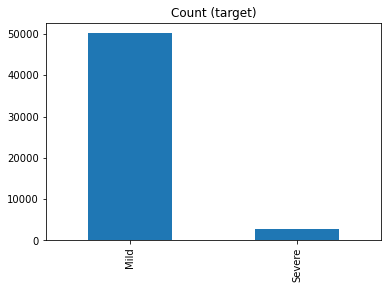

In [30]:
target_count = dataframe_final.SEVERITYCODE.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [32]:
#S Seperate out majority and minority classes
df_majority = dataframe_final[dataframe_final.SEVERITYCODE=='Mild']
df_minority = dataframe_final[dataframe_final.SEVERITYCODE=='Severe']

# upsample minority
df_minority_upsampled = resample(df_minority,
                         replace = True, # sample with replacement
                         n_samples = len(df_majority), # match number in majority class
                         random_state = 27) # reproducible results# combine majority and upsampled minority

df_upsampled = pd.concat([df_majority, df_minority_upsampled]) # check new class counts

df_upsampled.SEVERITYCODE.value_counts()

Severe    50157
Mild      50157
Name: SEVERITYCODE, dtype: int64

Class 0: 50157
Class 1: 50157
Proportion: 1.0 : 1


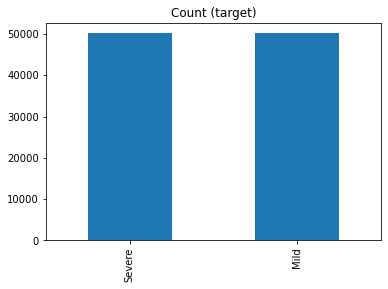

In [33]:
target_count1 = df_upsampled.SEVERITYCODE.value_counts()
print('Class 0:', target_count1[0])
print('Class 1:', target_count1[1])
print('Proportion:', round(target_count1[0] / target_count1[1], 2), ': 1')

target_count1.plot(kind='bar', title='Count (target)');

### Feature Selection

In [34]:
Features = df_upsampled[['COLLISIONTYPE_Angles', 
                            'COLLISIONTYPE_Cycles',
                            'COLLISIONTYPE_Head On',
                            'COLLISIONTYPE_Left Turn',
                            'COLLISIONTYPE_Parked Car',
                            'COLLISIONTYPE_Pedestrian',
                            'COLLISIONTYPE_Rear Ended',
                            'COLLISIONTYPE_Right Turn',
                            'COLLISIONTYPE_Sideswipe',
                            'WEATHER_Clear',
                            'WEATHER_Fog/Smog/Smoke',
                            'WEATHER_Overcast',
                            'WEATHER_Raining',
                            'WEATHER_Snowing',
                            'ROADCOND_Dry',
                            'ROADCOND_Ice',
                            'ROADCOND_Oil',
                            'ROADCOND_Sand/Mud/Dirt',
                            'ROADCOND_Snow/Slush',
                            'ROADCOND_Standing Water',
                            'ROADCOND_Wet',
                            'LIGHTCOND_Dark - No Street Lights',
                            'LIGHTCOND_Dark - Street Lights On',
                            'LIGHTCOND_Dawn',
                            'LIGHTCOND_Daylight',
                            'LIGHTCOND_Dusk']]
X = Features

In [35]:
X.shape

(100314, 26)

In [36]:
y = df_upsampled['SEVERITYCODE'].values
y.shape

(100314,)

In [37]:
df_upsampled['SEVERITYCODE'].value_counts()

Severe    50157
Mild      50157
Name: SEVERITYCODE, dtype: int64

### Normalize data
Data Standardization gives our data a zero mean and a one unit variance.

In [38]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 1.88936432, -0.37771899, -0.17940375, -0.34146372, -0.23210659,
        -0.55357389, -0.47794872, -0.1006484 , -0.2015521 ,  0.71956265,
        -0.04569254, -0.42152656, -0.47711445, -0.05252572,  0.59892902,
        -0.0585747 , -0.00998483, -0.01093795, -0.04656068, -0.01868224,
        -0.58945334, -0.11328199, -0.62297869, -0.13066718,  0.7240997 ,
        -0.19022067],
       [-0.52927855, -0.37771899, -0.17940375, -0.34146372, -0.23210659,
        -0.55357389,  2.09227469, -0.1006484 , -0.2015521 , -1.38973305,
        -0.04569254, -0.42152656,  2.09593317, -0.05252572, -1.66964694,
        -0.0585747 , -0.00998483, -0.01093795, -0.04656068, -0.01868224,
         1.69648713, -0.11328199,  1.60519133, -0.13066718, -1.38102528,
        -0.19022067],
       [ 1.88936432, -0.37771899, -0.17940375, -0.34146372, -0.23210659,
        -0.55357389, -0.47794872, -0.1006484 , -0.2015521 ,  0.71956265,
        -0.04569254, -0.42152656, -0.47711445, -0.05252572,  0.59892902,
       

### Have a quick look at our training and testing sets

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (80251, 26) (80251,)
Test set: (20063, 26) (20063,)


## Classification modelling:
In this phase, we will use the following machine learning models:
1. K Nearest Neighbour
2. Decision Tree
3. Support Vector Machines
4. Logistic Regression

In [40]:
### K Nearest Neighbor (KNN)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 5
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    # Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_KNN_test=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_KNN_test)

    
    std_acc[n-1]=np.std(yhat_KNN_test==y_test)/np.sqrt(yhat_KNN_test.shape[0])

mean_acc

array([0.62936749, 0.604446  , 0.64172856, 0.62652644])

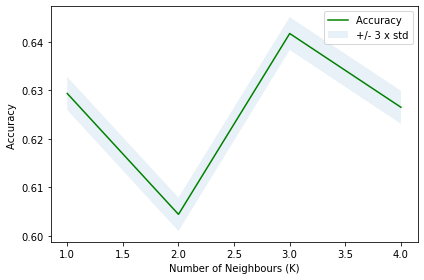

In [41]:
plt.plot(range(1,5),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3 x std'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

From the figure above we can see that 3 nearest neighbours will be sufficient for max accuracy. So we will use this number for our KNN model.

In [42]:
k = 3
KNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
KNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [43]:
# Sanity check
yhat_KNN = KNN_model.predict(X_test)
yhat_KNN[0:5]

array(['Severe', 'Mild', 'Severe', 'Mild', 'Severe'], dtype=object)

### Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
DT_model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [45]:
yhat_DT = DT_model.predict(X_test)
yhat_DT

array(['Severe', 'Mild', 'Severe', ..., 'Severe', 'Severe', 'Mild'],
      dtype=object)

### Support Vector Machine

In [46]:
from sklearn.svm import SVC
SVM_clf = SVC()
SVM_clf.fit(X_train, y_train) 

/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [47]:
yhat_SVM = SVM_clf.predict(X_test)
yhat_SVM

array(['Severe', 'Mild', 'Severe', ..., 'Severe', 'Severe', 'Mild'],
      dtype=object)

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model

/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
yhat_LR = LR_model.predict(X_test)
yhat_LR

array(['Severe', 'Mild', 'Severe', ..., 'Severe', 'Severe', 'Mild'],
      dtype=object)

## Evaluation Modelling

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

        Mild       0.65      0.61      0.63     10010
      Severe       0.63      0.67      0.65     10053

    accuracy                           0.64     20063
   macro avg       0.64      0.64      0.64     20063
weighted avg       0.64      0.64      0.64     20063

Confusion matrix, without normalization
[[6100 3910]
 [3278 6775]]


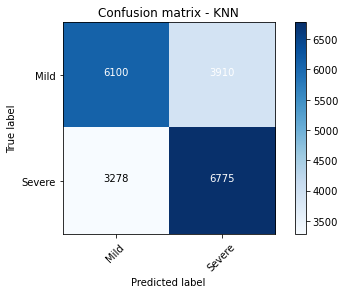

In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_KNN, labels=['Mild','Severe'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_KNN))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Mild','Severe'],normalize= False,  title='Confusion matrix - KNN')

              precision    recall  f1-score   support

        Mild       0.64      0.78      0.70     10010
      Severe       0.72      0.56      0.63     10053

    accuracy                           0.67     20063
   macro avg       0.68      0.67      0.66     20063
weighted avg       0.68      0.67      0.66     20063

Confusion matrix, without normalization
[[7806 2204]
 [4452 5601]]


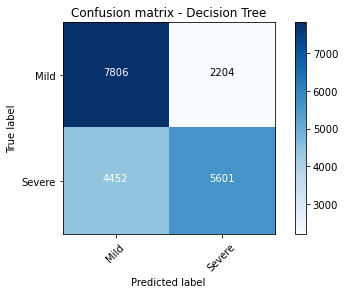

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_DT, labels=['Mild','Severe'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_DT))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Mild','Severe'],normalize= False,  title='Confusion matrix - Decision Tree')

              precision    recall  f1-score   support

        Mild       0.66      0.73      0.69     10010
      Severe       0.70      0.62      0.66     10053

    accuracy                           0.68     20063
   macro avg       0.68      0.68      0.67     20063
weighted avg       0.68      0.68      0.67     20063

Confusion matrix, without normalization
[[7296 2714]
 [3797 6256]]


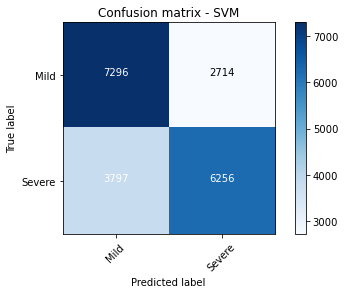

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_SVM, labels=['Mild','Severe'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_SVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Mild','Severe'],normalize= False,  title='Confusion matrix - SVM')

              precision    recall  f1-score   support

        Mild       0.65      0.74      0.69     10010
      Severe       0.70      0.60      0.65     10053

    accuracy                           0.67     20063
   macro avg       0.67      0.67      0.67     20063
weighted avg       0.67      0.67      0.67     20063

Confusion matrix, without normalization
[[7378 2632]
 [3991 6062]]


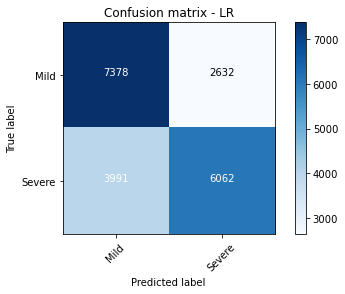

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_LR, labels=['Mild','Severe'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_LR))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Mild','Severe'],normalize= False,  title='Confusion matrix - LR')

In [56]:
import sklearn
print(sklearn.__version__)

0.21.3


In [57]:
### Model Evaluation
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Jaccard Index Evaluation

In [58]:
KNN_Jaccard_Index = jaccard_similarity_score(y_test, yhat_KNN)
DT_Jaccard_Index = jaccard_similarity_score(y_test, yhat_DT)
SVM_Jaccard_Index = jaccard_similarity_score(y_test, yhat_SVM)
LR_Jaccard_Index = jaccard_similarity_score(y_test, yhat_LR)

/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/Users/u4307082/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23.

### F1 Evaluation

In [59]:
KNN_f1 = f1_score(y_test, yhat_KNN, average='weighted')
DT_f1 = f1_score(y_test, yhat_DT, average='weighted')
SVM_f1 = f1_score(y_test, yhat_SVM, average='weighted')
LR_f1 = f1_score(y_test, yhat_LR, average='weighted')

### Evaluation Summary

In [60]:
print("KNN Jaccard index: %.2f" % KNN_Jaccard_Index)
print("Decision Tree Jaccard index: %.2f" % DT_Jaccard_Index)
print("SVM Jaccard index: %.2f" % SVM_Jaccard_Index)
print("Logistic Regression Jaccard index: %.2f" % LR_Jaccard_Index)

KNN Jaccard index: 0.64
Decision Tree Jaccard index: 0.67
SVM Jaccard index: 0.68
Logistic Regression Jaccard index: 0.67


In [61]:
print("KNN F1: %.2f" % KNN_f1)
print("Decision Tree F1: %.2f" % DT_f1)
print("SVM F1: %.2f" % SVM_f1)
print("Logistic Regression F1: %.2f" % LR_f1)

KNN F1: 0.64
Decision Tree F1: 0.66
SVM F1: 0.67
Logistic Regression F1: 0.67
